### Using PCA as an EDA technique
inspiration: [this tweet](https://twitter.com/__mharrison__/status/1636366804137263105)

Unfortunately, the trail has run cold...I can't figure out where he's creating the `res` dataframe. Boo.

But, still learned a bunch, especially the unpacking of dictionaries with stuff like:
```**{k: lambda df_, col=k: df_[col].fillna(0).astype(float) for k in number_cols}```

Hard core pythonic!

In [2]:
import pandas as pd

In [3]:
ames = pd.read_csv('./AmesHousing.csv')  # dataset download from kaggle (see README.md for url)

### First, some package-based EDA
I tried `dataprep` cuz it looks simpler and more visually appealing but it doesn't install under Python 3.11 and doesn't work (at least `create_report(df)` didn't) under 3.10.

So, here's what used to be `pandas-profiling`...renamed to `ydata-profiling`.

Nope.  `ydata-profling` doesn't work either.  It kinda does as it gives a histogram for every variable but every section subsequent isn't produced.  The HTML is jacked.  Could be a 3.11 thing as nothing looks updated from when I used to use it in prior Python versions.

In [3]:
from ydata_profiling import ProfileReport

In [4]:
profile = ProfileReport(ames, title="Dude Profiling Report")

In [5]:
profile.to_file("dude_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Back to Matt's voodoo

Note: it's appears to be voodoo because most of the heavy lifting (ie, `tweak_ames()`) is done in [this tweet](https://twitter.com/__mharrison__/status/1582393269643665408) and replicated below.

In [25]:
rating_cols = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Kitchen Qual', 
               'Garage Qual', 'Garage Cond', 'Heating QC', 'Fireplace Qu', 'Pool QC']

ames[rating_cols]

,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Kitchen Qual,Garage Qual,Garage Cond,Heating QC,Fireplace Qu,Pool QC
0,TA,TA,TA,Gd,TA,TA,TA,Fa,Gd,NaN
1,TA,TA,TA,TA,TA,TA,TA,TA,NaN,NaN
2,TA,TA,TA,TA,Gd,TA,TA,TA,NaN,NaN
3,Gd,TA,TA,TA,Ex,TA,TA,Ex,TA,NaN
4,TA,TA,Gd,TA,TA,TA,TA,Gd,TA,NaN
...,...,...,...,...,...,...,...,...,...,...
2925,TA,TA,TA,TA,TA,TA,TA,TA,NaN,NaN
2926,TA,TA,Gd,TA,TA,TA,TA,TA,NaN,NaN
2927,TA,TA,Gd,TA,TA,NaN,NaN,TA,NaN,NaN
2928,TA,TA,Gd,TA,TA,TA,TA,Gd,TA,NaN


In [59]:
def tweak_ames(ames):
    def rating_to_num(df, col):
        return df[col].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    
    rating_cols = ['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'kitchen_qual', 
                   'garage_qual', 'garage_cond', 'heating_qc', 'fireplace_qc', 'pool_qc']

    category_cols = ['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
                     'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2',
                     'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st',
                     'exterior_2nd', 'mas_vnr_type', 'foundation', 'bsmt_exposure', 'bsmtfin_type_1',
                     'bsmtfin_type_2', 'heating', 'electrical', 'functional', 'garage_type',
                     'garage_finish', 'paved_drive', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
    
    number_cols = ['lot_frontage', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf',
                   'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_cars', 'garage_area']

    uint8_cols = ['ms_subclass', 'overall_qual', 'overall_cond', 'full_bath', 'half_bath', 'bedroom_abvgr',
                  'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'mo_sold']
    
    uint16_cols = ['order', 'year_built', 'year_remod/add', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
                   'gr_liv_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch',
                   'screen_porch', 'pool_area', 'misc_val', 'yr_sold']
    
    uint32_cols = ['lot_area', 'saleprice']

    return (ames
        .rename(columns=lambda c: c.lower().replace(' ', '_'))
        .assign(
            stories=lambda df_: df_.house_style.str.extract(r'(\d\.?\d?)').astype(float).fillna(0),
            has_bsmt=lambda df_: ~df_.bsmt_qual.isna(),
            has_garage=lambda df_: ~df_.garage_qual.isna(),
            **{k: lambda df_: rating_to_num(df_, k).fillna(0) for k in rating_cols},
            garage_yr_blt=lambda df_: df_.garage_yr_blt.fillna(df_.year_built).astype('uint16'),
            **{k: lambda df_, col=k: df_[col].fillna('Other').astype('category') for k in category_cols},
            **{k: lambda df_, col=k: df_[col].fillna(0).astype(float) for k in number_cols},
            total_sf = lambda df_: df_.total_bsmt_sf + df_['1st_flr_sf'] + df_['2nd_flr_sf']
        )
        .astype({
            'central_air': bool,
            **{k: 'uint8' for k in uint8_cols},
            **{k: 'uint16' for k in uint16_cols},
            **{k: 'uint32' for k in uint32_cols}
        })
        .drop(columns=['pid'])
	)

In [60]:
dude = tweak_ames(ames)

<AxesSubplot: xlabel='year_built'>

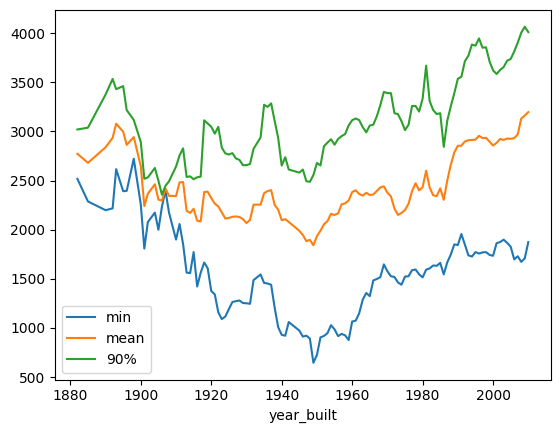

In [79]:
(dude 
    .groupby('year_built')
    [['total_sf']]
    .agg(['min', 'mean', lambda g: g.quantile(.9)])
    .total_sf  # this is necessary since the resulting agg will have two levels of column names:  total_sf and (min, miean, 90)
    .rename(columns={'<lambda_0>': '90%'})
    .rolling(5).mean()  # smooths out the jaggedness
    .plot()
)